# **Import Dependencies**

In [45]:
!pip install google-play-scraper pandas

In [46]:
!pip install wordcloud

In [47]:
!pip install vaderSentiment

# **Import Library**

In [48]:
from google_play_scraper import app, reviews, Sort, reviews_all

import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
seed = 0
np.random.seed(seed)

import time
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Scrapping menggunakan google play scraper**

In [49]:
app_id = 'jp.konami.pesam'  # ID app brimo
total_reviews = 32000
batch_size = 4000
review_df = []


while len(review_df) < total_reviews:
    try:
        result, _ = reviews(
            app_id,
            lang='en',
            country='us',
            sort=Sort.MOST_RELEVANT,
            count=batch_size,
            continuation_token=None if not review_df else token  # untuk lanjut dari review sebelumnya
        )
        review_df.extend(result)
        token = _  # update continuation token untuk batch berikutnya
        print(f"Jumlah review terkumpul: {len(review_df)}")
        time.sleep(1)
    except Exception as e:
        print("Terjadi error:", e)
        break


Jumlah review terkumpul: 4000
Jumlah review terkumpul: 8000
Jumlah review terkumpul: 12000
Jumlah review terkumpul: 16000
Jumlah review terkumpul: 20000
Jumlah review terkumpul: 24000
Jumlah review terkumpul: 28000
Jumlah review terkumpul: 32000


In [50]:

df = pd.DataFrame(review_df)
df = df[['at','userName', 'score', 'content']]
df.to_csv('df_efootball.csv', index=False)

print("Total review yang disimpan:", len(df))


Total review yang disimpan: 32000


# **Membaca Dataset**

In [51]:
df = pd.read_csv("df_efootball.csv")

In [52]:
df.head()

,at,userName,score,content
0,2025-02-20 07:02:41,A Google user,3,"Finally learnt how to play efootball, and it's..."
1,2025-03-16 19:15:17,A Google user,5,Nice game I've played so far but some things c...
2,2025-04-06 00:56:51,A Google user,1,The game has serious issues with online gamepl...
3,2025-02-22 10:56:18,A Google user,3,The game has come a long way from it's last up...
4,2025-02-24 09:25:37,A Google user,2,The game itself is pretty good. We enjoy playi...


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   at        32000 non-null  object
 1   userName  32000 non-null  object
 2   score     32000 non-null  int64 
 3   content   32000 non-null  object
dtypes: int64(1), object(3)
memory usage: 1000.1+ KB


# **Pre-Processing Dataset**

## **Pembersihan Data**

In [54]:
df = df.drop_duplicates(subset=['content'])
print("Jumlah data setelah duplikat dibuang:", len(df))

Jumlah data setelah duplikat dibuang: 31986


In [55]:
df.isnull().sum()

,0
at,0
userName,0
score,0
content,0


In [56]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)
    text = re.sub(r'rt[\s]+', '', text)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.encode('ascii', 'ignore').decode('ascii')
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df['cleaned_content'] = df['content'].apply(cleaningText)

## **Casefolding**

In [57]:
def casefoldingText(text):
    text = text.lower()
    return text

df['cleaned_content'] = df['cleaned_content'].apply(casefoldingText)

## **Tokenisasi**

In [58]:
def tokenizingText(text):
    text = word_tokenize(text)
    return text

df['cleaned_content'] = df['cleaned_content'].apply(casefoldingText)

## **Pembersihan Stopwords**

In [59]:
all_stopwords = set(stopwords.words('english'))

def RemoveStopword(text):
    words = text.split()
    filtered_words = [word for word in words if word not in all_stopwords]
    return ' '.join(filtered_words)

df['cleaned_content'] = df['cleaned_content'].apply(RemoveStopword)

## **Normalisasi**

In [60]:
slang_dict = {
    "u": "you",
    "ur": "your",
    "r": "are",
    "ya": "you",
    "btw": "by the way",
    "idk": "i do not know",
    "imo": "in my opinion",
    "lmk": "let me know",
    "omg": "oh my god",
    "thx": "thanks",
    "ty": "thank you",
    "pls": "please",
    "plz": "please",
    "smh": "shaking my head",
    "lol": "laughing out loud",
    "b4": "before",
    "gr8": "great",
    "cuz": "because",
    "coz": "because",
    "wanna": "want to",
    "gonna": "going to",
    "gotta": "got to",
    "kinda": "kind of",
    "lemme": "let me",
    "ain't": "is not",
    "imma": "i am going to",
    "ya'll": "you all"
}

In [61]:
def normalize_slang(text):
    words = text.split()
    normalized_words = [slang_dict[word.lower()] if word.lower() in slang_dict else word for word in words]
    return ' '.join(normalized_words)

df['cleaned_content'] = df['cleaned_content'].apply(normalize_slang)

## **Lemmatization**

In [62]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word, pos='v') for word in words]
    return ' '.join(lemmatized_words)

df['cleaned_content'] = df['cleaned_content'].apply(lemmatize_text)

In [63]:
def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

df['content'] = df['cleaned_content'].apply(toSentence)

In [64]:
df.to_csv('hasil_preprocessing.csv', index=False)

In [65]:
# from google.colab import drive
# drive.mount('/content/drive')

# df.to_csv('/content/drive/MyDrive/hasil_preprocessing.csv', index=False)


## **Labelling**

In [66]:
df[['content', 'cleaned_content']].sample(15)

,content,cleaned_content
253,g a m e a w e s o m e t h i n g s g o o ...,game awesome things good like open card player...
12172,w e l l c h e c k f o r e i t o p t i o ...,well check foreit option play person online ha...
31634,p l a y s i n c e y e a r s t a r t t ...,play since year start tp play game run smoothl...
6475,p e s p o o r f i r s t t o u c h s l ...,pes poor first touch slow reaction make player...
29432,p e s p r o b l e m g a m e m y e v e n ...,pes problem gamemy event mode iconic player ag...
26406,d o n t i s s u e k o n a m i w a n t ...,dont issue konami want prime ronaldo bring mes...
29554,g a m e g r e a t n i c e g r a p h i c ...,game great nice graphics mobile nice gameplay ...
18758,k i n d g a m e u p d a t e u s p l a ...,kind game update us play game control self pas...
4039,g a m e n i c e l i k e e v e n c o n ...,game nice like even control think must update ...
409,b e s t g a m e e v e r p o s s i b l e ...,best game ever possible please add boot wear r...


In [67]:
analyzer = SentimentIntensityAnalyzer()

In [68]:
def get_sentiment_label(text):
    score = analyzer.polarity_scores(text)
    compound = score['compound']
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['label'] = df['cleaned_content'].apply(get_sentiment_label)

In [69]:
df.head()

,at,userName,score,content,cleaned_content,label
0,2025-02-20 07:02:41,A Google user,3,f i n a l l y l e a r n p l a y e f o o ...,finally learn play efootball little bite easie...,positive
1,2025-03-16 19:15:17,A Google user,5,n i c e g a m e i v e p l a y f a r ...,nice game ive play far things make better leag...,positive
2,2025-04-06 00:56:51,A Google user,1,g a m e s e r i o u s i s s u e o n l i ...,game serious issue online gameplay match often...,negative
3,2025-02-22 10:56:18,A Google user,3,g a m e c o m e l o n g w a y l a s t ...,game come long way last update enjoyable play ...,positive
4,2025-02-24 09:25:37,A Google user,2,g a m e p r e t t y g o o d e n j o y ...,game pretty good enjoy play vs ai match countr...,positive


label
positive    23421
negative     7793
neutral       772
Name: count, dtype: int64


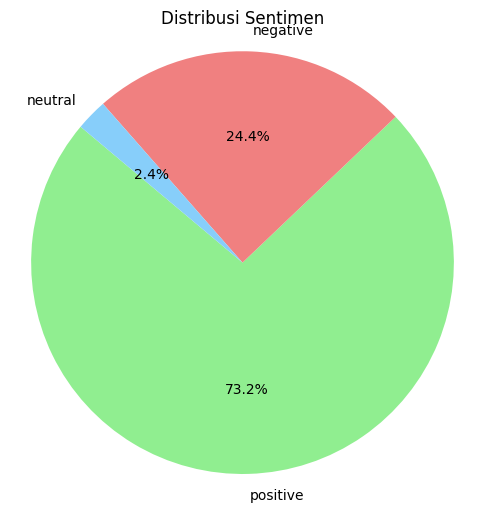

In [70]:
sentiment_counts = df['label'].value_counts()
print(sentiment_counts)
plt.figure(figsize=(6,6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['lightgreen', 'lightcoral', 'lightskyblue'])
plt.title('Distribusi Sentimen')
plt.axis('equal')  # Biar bulat
plt.show()

## **WorldCloud**

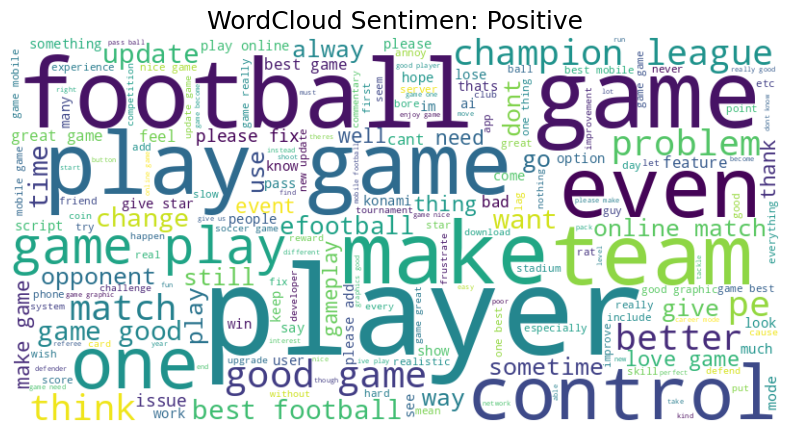

In [71]:
# Fungsi untuk generate dan tampilkan WordCloud
def generate_wordcloud_per_label(df, label):
    filtered_df = df[df['label'] == label]

    if filtered_df.empty:
        print(f"Tidak ada data dengan label '{label}'")
        return

    text = ' '.join(filtered_df['cleaned_content'])

    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        max_words=200,
        colormap='viridis'
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud Sentimen: {label.capitalize()}', fontsize=18)
    plt.show()


generate_wordcloud_per_label(df, 'positive')

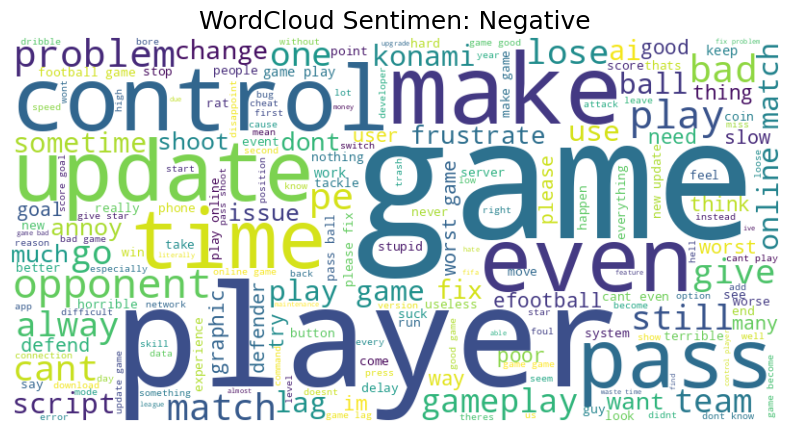

In [72]:
generate_wordcloud_per_label(df, 'negative')

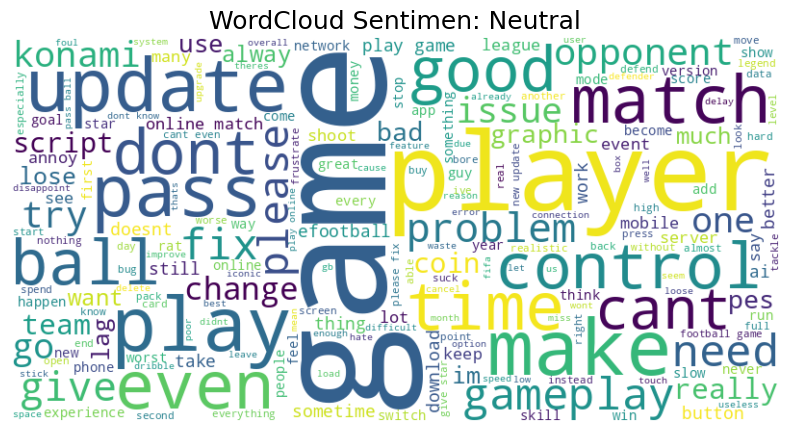

In [73]:
generate_wordcloud_per_label(df, 'neutral')

# **Eksport Dataset**

In [74]:
df_export = df[['cleaned_content', 'score', 'label', 'at']]

df_export.to_csv('preprocessed_efootball_reviews.csv', index=False)
